## 1️⃣ Analyse des données

### Tâches
1. Examiner la structure du dataset.
2. Détecter et traiter les valeurs manquantes et doublons.
3. Analyser la distribution de la variable cible.
4. Générer des WordClouds.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import time

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ramas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 1. Chargement et Inspection des données

In [2]:
df = pd.read_csv('../data/raw/DataSet_Emails.csv')

df.shape

(31716, 8)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31716 entries, 0 to 31715
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31716 non-null  int64 
 1   message_id  31716 non-null  int64 
 2   text        31665 non-null  object
 3   label       31716 non-null  int64 
 4   label_text  31716 non-null  object
 5   subject     31442 non-null  object
 6   message     31371 non-null  object
 7   date        31716 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.9+ MB


In [4]:
print(f"Dimensions du dataset : {df.shape}")

Dimensions du dataset : (31716, 8)


### 2. Nettoyage des données (Valeurs manquantes et Doublons)

In [5]:
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
Unnamed: 0      0
message_id      0
text           51
label           0
label_text      0
subject       274
message       345
date            0
dtype: int64


In [6]:
df = df.drop(columns=['Unnamed: 0', 'message_id', 'subject', 'message', 'date'])

df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]


In [7]:
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
text          0
label         0
label_text    0
dtype: int64


In [8]:
# Vérification des doublons
doublons = df.duplicated().sum()
print(f"Nombre de doublons : {doublons}")

Nombre de doublons : 2854


In [9]:
# Suppression des doublons
print(f"Dimensions avant suppression des doublons : {df.shape}")
df = df.drop_duplicates()
print(f"Dimensions après suppression des doublons : {df.shape}")

Dimensions avant suppression des doublons : (31665, 3)
Dimensions après suppression des doublons : (28811, 3)


### 3. Analyse de la distribution (Spam vs Ham)

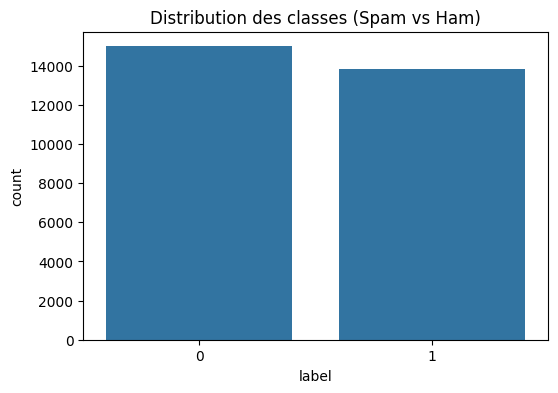

label
0    0.52001
1    0.47999
Name: proportion, dtype: float64


In [10]:
# Visualisation de la distribution
target_col = 'label'

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title('Distribution des classes (Spam vs Ham)')
plt.show()

print(df[target_col].value_counts(normalize=True))

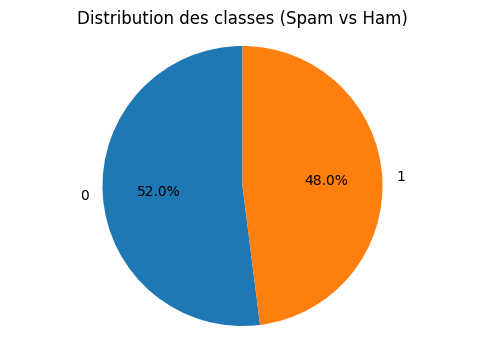

label
0    0.52001
1    0.47999
Name: proportion, dtype: float64


In [11]:

counts = df[target_col].value_counts()
labels = counts.index
sizes = counts.values

plt.figure(figsize=(6, 4))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution des classes (Spam vs Ham)')
plt.axis('equal')
plt.show()

print(df[target_col].value_counts(normalize=True))

In [12]:
# les colonnes : 
print(df.columns)
df.head(5)

Index(['text', 'label', 'label_text'], dtype='object')


,text,label,label_text
0,any software just for 15 $ - 99 $ understandin...,1,spam
1,perspective on ferc regulatory action client c...,0,ham
2,wanted to try ci 4 lis but thought it was way ...,1,spam
3,"enron / hpl actuals for december 11 , 2000 tec...",0,ham
4,looking for cheap high - quality software ? ro...,1,spam


### 4. WordClouds

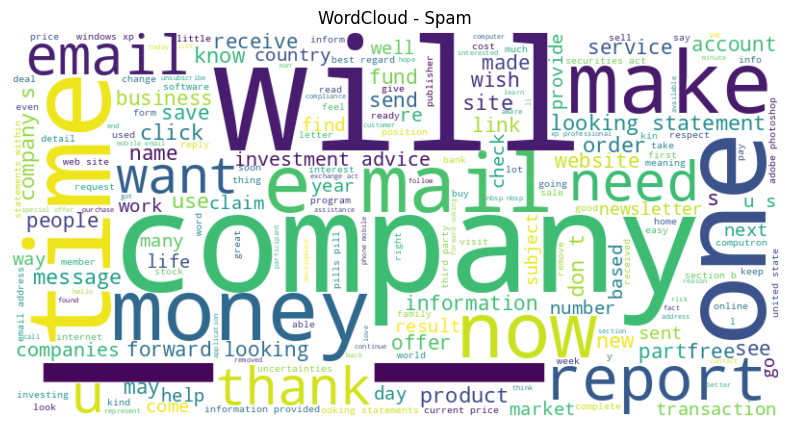

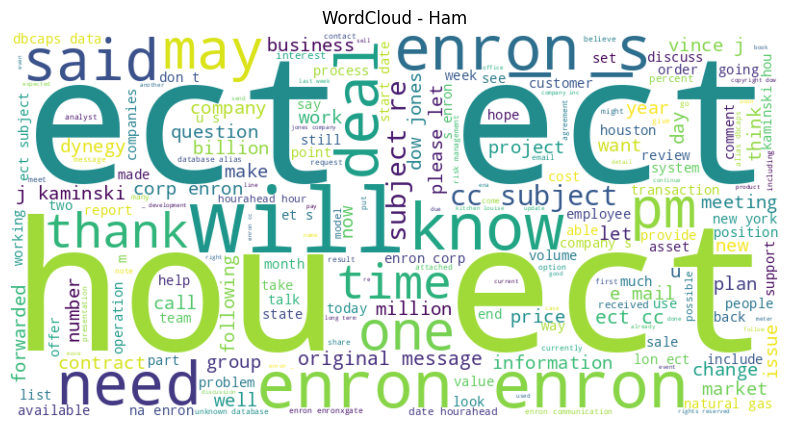

In [13]:
# Fonction pour générer un WordCloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


spam_text = " ".join(df[df['label_text'] == 'spam']['text'].astype(str).tolist())
ham_text = " ".join(df[df['label_text'] == 'ham']['text'].astype(str).tolist())

# WordCloud Spam
plot_wordcloud(spam_text, "WordCloud - Spam")

# WordCloud Ham
plot_wordcloud(ham_text, "WordCloud - Ham")

## 2️⃣ Prétraitement du texte

### Tâches
1. Nettoyage et normalisation du texte
2. Tokenisation et filtrage des mots
3. Vectorisation du texte


### 1. Nettoyage et normalisation du texte

#### ➕ Convertir tout le texte en minuscules

In [14]:
#
df['text'] = df['text'].str.lower().str.strip()
# df['subject'] = df['subject'].str.lower().str.strip()

#### ➕ Supprimer les lignes vides ou incomplètes

In [15]:
df.isnull().sum()

text          0
label         0
label_text    0
dtype: int64

In [16]:
df = df.dropna(subset=["text"])

df["text"] = df["text"].str.strip()

df = df[df["text"] != ""]

df.shape

(28811, 3)

#### ➕ Supprimer la ponctuation et les caractères spéciaux

In [17]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # URLs
    text = re.sub(r'\S+@\S+', '', text)  # emails
    text = re.sub(r'\d+', '', text)  # chiffres
    text = text.translate(str.maketrans('', '', string.punctuation))  # ponctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['text'] = df['text'].apply(clean_text)

df.head(5)


,text,label,label_text
0,any software just for understanding oem softwa...,1,spam
1,perspective on ferc regulatory action client c...,0,ham
2,wanted to try ci lis but thought it was way to...,1,spam
3,enron hpl actuals for december teco tap enron ...,0,ham
4,looking for cheap high quality software rotate...,1,spam


In [18]:
df['text'].isna().sum()

np.int64(0)

In [19]:
df_null = df[(df['text'] == "")]
df = df[df['text'] != ""]
df.shape

(28808, 3)

In [20]:
df_null.head()

,text,label,label_text
9648,,1,spam
10562,,1,spam
24407,,1,spam


In [21]:
df.shape


(28808, 3)

### 2. Tokenisation et filtrage des mots

#### ➕ Tokeniser le texte

In [22]:

def tokenize_text(text):
    return word_tokenize(text)

df['text_tokenized'] = df['text'].apply(tokenize_text)
df.head()


,text,label,label_text,text_tokenized
0,any software just for understanding oem softwa...,1,spam,"[any, software, just, for, understanding, oem,..."
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, on, ferc, regulatory, action, cl..."
2,wanted to try ci lis but thought it was way to...,1,spam,"[wanted, to, try, ci, lis, but, thought, it, w..."
3,enron hpl actuals for december teco tap enron ...,0,ham,"[enron, hpl, actuals, for, december, teco, tap..."
4,looking for cheap high quality software rotate...,1,spam,"[looking, for, cheap, high, quality, software,..."


#### ➕ Supprimer les stopwords

In [23]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['text_no_stopwords'] = df['text_tokenized'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,label_text,text_tokenized,text_no_stopwords
0,any software just for understanding oem softwa...,1,spam,"[any, software, just, for, understanding, oem,...","[software, understanding, oem, software, lead,..."
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, on, ferc, regulatory, action, cl...","[perspective, ferc, regulatory, action, client..."
2,wanted to try ci lis but thought it was way to...,1,spam,"[wanted, to, try, ci, lis, but, thought, it, w...","[wanted, try, ci, lis, thought, way, expensive..."
3,enron hpl actuals for december teco tap enron ...,0,ham,"[enron, hpl, actuals, for, december, teco, tap...","[enron, hpl, actuals, december, teco, tap, enr..."
4,looking for cheap high quality software rotate...,1,spam,"[looking, for, cheap, high, quality, software,...","[looking, cheap, high, quality, software, rota..."


#### ➕ Appliquer le stemming (PorterStemmer)

In [24]:
stemmer = PorterStemmer()

def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]

df['text_stemmed'] = df['text_no_stopwords'].apply(stem_text)
df.head()

,text,label,label_text,text_tokenized,text_no_stopwords,text_stemmed
0,any software just for understanding oem softwa...,1,spam,"[any, software, just, for, understanding, oem,...","[software, understanding, oem, software, lead,...","[softwar, understand, oem, softwar, lead, temp..."
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, on, ferc, regulatory, action, cl...","[perspective, ferc, regulatory, action, client...","[perspect, ferc, regulatori, action, client, c..."
2,wanted to try ci lis but thought it was way to...,1,spam,"[wanted, to, try, ci, lis, but, thought, it, w...","[wanted, try, ci, lis, thought, way, expensive...","[want, tri, ci, li, thought, way, expens, viag..."
3,enron hpl actuals for december teco tap enron ...,0,ham,"[enron, hpl, actuals, for, december, teco, tap...","[enron, hpl, actuals, december, teco, tap, enr...","[enron, hpl, actual, decemb, teco, tap, enron,..."
4,looking for cheap high quality software rotate...,1,spam,"[looking, for, cheap, high, quality, software,...","[looking, cheap, high, quality, software, rota...","[look, cheap, high, qualiti, softwar, rotat, n..."


In [25]:
df['text_stemmed'][0]

['softwar',
 'understand',
 'oem',
 'softwar',
 'lead',
 'temptat',
 'find',
 'way',
 'law',
 'disregard',
 'trifl']

### 3. Vectorisation du texte

#### ➕ split data : 

In [26]:
X = df['text_stemmed']
y = df['label'].map({'ham':0, 'spam':1}) if df['label'].dtype == object else df['label']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### ➕ Appliquer TF-IDF ou CountVectorizer

In [27]:


X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

print(X_train.head())
print(X_test.head())

14367    chemist provid custom wide select qualiti medi...
25946    power propos houston visit ehud thank fro mess...
28056    worldpow mark agre seem market penetr need ben...
21030    lng may decis john ye addit info transact vinc...
5108     resum marshal shall call wednesday vinc marsha...
Name: text_stemmed, dtype: object
25761    tadalafil soft tab great result hi new product...
20867    wow never onlin anyor dear rait bruce guenter ...
25254    bpa feb loss bill pleas advis bill bpa tranni ...
12443    astound mortgag simplifi homeown pre approv ho...
17791    special asset statu attach june narr report un...
Name: text_stemmed, dtype: object


In [28]:
train_df = pd.DataFrame({'text_final': X_train, 'label': y_train})
test_df = pd.DataFrame({'text_final': X_test, 'label': y_test})

In [29]:

# Vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Fit and Transform
tfidf_train = vectorizer.fit_transform(train_df['text_final'])
tfidf_test = vectorizer.transform(test_df['text_final'])


In [30]:
print(f"===> tfidf_train.shape : {tfidf_train.shape}  pourcentage :  {((tfidf_train.shape[0]/df.shape[0])*100):.2f}")
print(f"===> tfidf_test.shape : { tfidf_test.shape}  pourcentage :  {((tfidf_test.shape[0]/df.shape[0])*100):.2f}")

row0 = tfidf_train[:10].toarray()
pd.DataFrame(row0, columns=vectorizer.get_feature_names_out())



===> tfidf_train.shape : (23046, 102224)  pourcentage :  80.00
===> tfidf_test.shape : (5762, 102224)  pourcentage :  20.00


,aa,aaa,aaaa,aaaaci,aaadrizzl,aaaenerfax,aaal,aaaplusdirect,aaasash,aab,...,þtý,þu,þya,þá,þãõ,þí,þîñõþàà,þô,þöyledir,þù
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaa', ..., 'þô', 'þöyledir', 'þù'],
      shape=(102224,), dtype=object)

## 3️⃣ Entraînement des modèles

### Tâches
1. Entraîner différents modèles (Logistic Regression, Random Forest, etc.)
2. Évaluer les modèles (précision, rappel, F1-score)
3. Optimiser les hyperparamètres si nécessaire


### 1. Entraînement des modèles de classification

#### ➕ Entraîner différents modèles (Logistic Regression, Random Forest, etc.)

In [32]:

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


models = {
    "NaiveBayes": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=300),
    "LinearSVC": LinearSVC(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

pipelines = {}

for name, clf in models.items():
    
    pipelines[name] = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words=stop_words)),
        ("clf", clf)
    ])
    



#### ➕ Évaluer les modèles (précision, rappel, F1-score)


==================== NaiveBayes ====================
Accuracy : 0.9828184658104825
Precision : 0.9828978068974129
Recall : 0.9828184658104825
F1_score : 0.982812984163425
time_total : 2.4287819862365723
AUC : 0.998352179786779

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2997
           1       0.99      0.98      0.98      2765

    accuracy                           0.98      5762
   macro avg       0.98      0.98      0.98      5762
weighted avg       0.98      0.98      0.98      5762



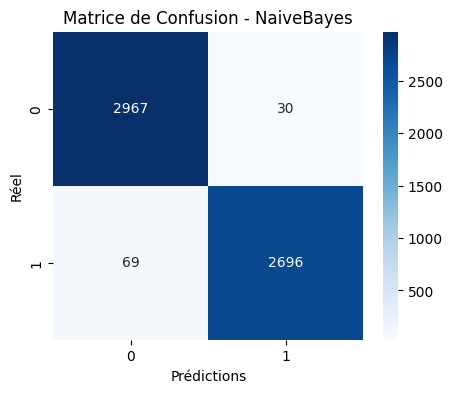


==================== LogisticRegression ====================
Accuracy : 0.9847275251648733
Precision : 0.9848842789900845
Recall : 0.9847275251648733
F1_score : 0.9847317153943809
time_total : 2.762194871902466
AUC : 0.9985668610141184

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2997
           1       0.98      0.99      0.98      2765

    accuracy                           0.98      5762
   macro avg       0.98      0.99      0.98      5762
weighted avg       0.98      0.98      0.98      5762



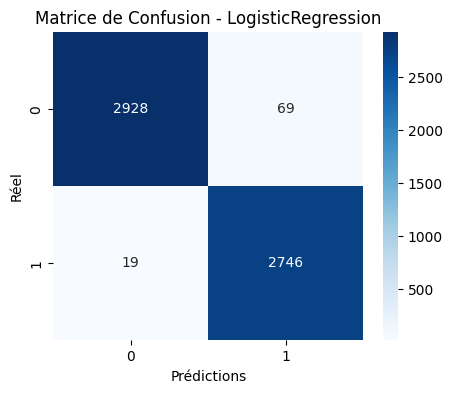


==================== LinearSVC ====================
Accuracy : 0.9895869489760499
Precision : 0.9896043986831954
Recall : 0.9895869489760499
F1_score : 0.9895880344413742
time_total : 2.402100086212158
AUC : 0.9992104219952321

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2997
           1       0.99      0.99      0.99      2765

    accuracy                           0.99      5762
   macro avg       0.99      0.99      0.99      5762
weighted avg       0.99      0.99      0.99      5762



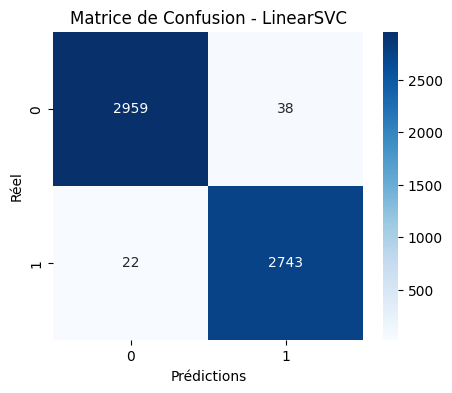


==================== RandomForest ====================
Accuracy : 0.9852481777160708
Precision : 0.985252491716129
Recall : 0.9852481777160708
F1_score : 0.9852488785941033
time_total : 43.54419255256653
AUC : 0.9985663179756007

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2997
           1       0.98      0.99      0.98      2765

    accuracy                           0.99      5762
   macro avg       0.99      0.99      0.99      5762
weighted avg       0.99      0.99      0.99      5762



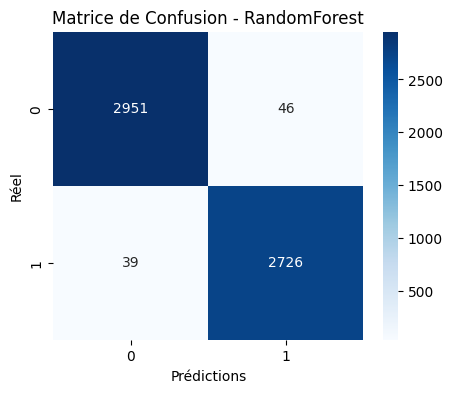


==================== GradientBoosting ====================
Accuracy : 0.9446372787226658
Precision : 0.9476793909471679
Recall : 0.9446372787226658
F1_score : 0.9446376639196818
time_total : 79.11136841773987
AUC : 0.9905936074712447

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2997
           1       0.91      0.98      0.94      2765

    accuracy                           0.94      5762
   macro avg       0.95      0.95      0.94      5762
weighted avg       0.95      0.94      0.94      5762



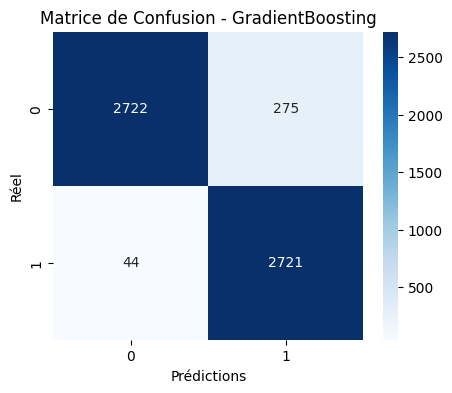

In [33]:


results = {}

for name, pipe in pipelines.items():
    print(f"\n==================== {name} ====================")
    start_time = time.time()
    
    # Entraînement
    pipe.fit(X_train, y_train)

    # Prédictions
    preds = pipe.predict(X_test)

    end_time = time.time()
    
    total_time = end_time - start_time
    
    
    # Accuracy
    acc = accuracy_score(y_test, preds)

    # Precision, Recall, F1
    precision = precision_score(y_test, preds, average="weighted", zero_division=0)
    recall = recall_score(y_test, preds, average="weighted", zero_division=0)
    f1 = f1_score(y_test, preds, average="weighted", zero_division=0)

    # AUC (se calcule seulement si problème binaire)
    auc = None
    if len(y.unique()) == 2:
        try:
            if hasattr(pipe, "predict_proba"):
                proba = pipe.predict_proba(X_test)[:, 1]
            elif hasattr(pipe, "decision_function"):
                proba = pipe.decision_function(X_test)
            else:
                proba = None

            if proba is not None:
                auc = roc_auc_score(y_test, proba)
        except:
            auc = None

    # Matrice de confusion
    cm = confusion_matrix(y_test, preds)

    # Stocker les résultats
    results[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1_score": f1,
        "AUC": auc,
        "Confusion_matrix": cm,
        "time_total": total_time
    }

    # Affichage
    print("Accuracy :", acc)
    print("Precision :", precision)
    print("Recall :", recall)
    print("F1_score :", f1)
    print("time_total :", total_time)
    if auc is not None:
        print("AUC :", auc)
    print("\n--- Rapport complet ---")
    print(classification_report(y_test, preds))

    # Matrice de confusion visuelle
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de Confusion - {name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.show()
    


In [34]:
pd.DataFrame(results)

,NaiveBayes,LogisticRegression,LinearSVC,RandomForest,GradientBoosting
Accuracy,0.982818,0.984728,0.989587,0.985248,0.944637
Precision,0.982898,0.984884,0.989604,0.985252,0.947679
Recall,0.982818,0.984728,0.989587,0.985248,0.944637
F1_score,0.982813,0.984732,0.989588,0.985249,0.944638
AUC,0.998352,0.998567,0.99921,0.998566,0.990594
Confusion_matrix,"[[2967, 30], [69, 2696]]","[[2928, 69], [19, 2746]]","[[2959, 38], [22, 2743]]","[[2951, 46], [39, 2726]]","[[2722, 275], [44, 2721]]"
time_total,2.428782,2.762195,2.4021,43.544193,79.111368


#### ➕ Entraînement des modèles de classification

In [35]:
param_grids = {
    "NaiveBayes": {
        "tfidf__min_df": [1, 3, 5],
        "clf__alpha": [0.5, 1.0]
    },
    "LogisticRegression": {
        "tfidf__min_df": [1, 3],
        "clf__C": [0.1, 1, 5],
        "clf__penalty": ["l2"]
    },
    "LinearSVC": {
        "tfidf__min_df": [1, 3],
        "clf__C": [0.1, 1, 5]
    },
    "RandomForest": {
        "tfidf__min_df": [1, 3],
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 20]
    },
    "GradientBoosting": {
        "tfidf__min_df": [1, 3],
        "clf__learning_rate": [0.05, 0.1],
        "clf__n_estimators": [100, 200]
    }
}



🔎 Optimisation : NaiveBayes
Meilleur score (validation) : 0.9848129827301918
Meilleurs paramètres : {'clf__alpha': 0.5, 'tfidf__min_df': 1}

===== Performance sur Test Set =====
Accuracy : 0.9845539743144741
Precision : 0.9846035134682961
Recall : 0.9845539743144741
F1_score : 0.9845501733533815
Temps total (sec) : 10.62
AUC : 0.9985147293164172

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2997
           1       0.99      0.98      0.98      2765

    accuracy                           0.98      5762
   macro avg       0.98      0.98      0.98      5762
weighted avg       0.98      0.98      0.98      5762



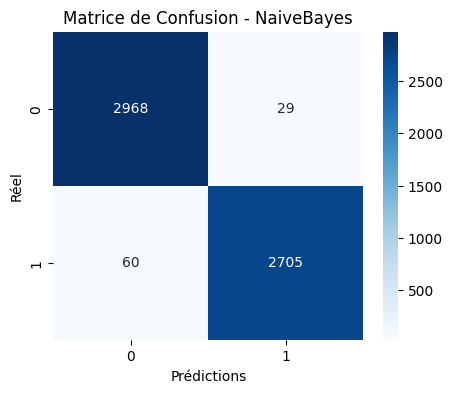


🔎 Optimisation : LogisticRegression
Meilleur score (validation) : 0.9867655992363099
Meilleurs paramètres : {'clf__C': 5, 'clf__penalty': 'l2', 'tfidf__min_df': 3}

===== Performance sur Test Set =====
Accuracy : 0.988545643873655
Precision : 0.9885963195130367
Recall : 0.988545643873655
F1_score : 0.9885476170099661
Temps total (sec) : 7.89
AUC : 0.9990641636211256

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2997
           1       0.98      0.99      0.99      2765

    accuracy                           0.99      5762
   macro avg       0.99      0.99      0.99      5762
weighted avg       0.99      0.99      0.99      5762



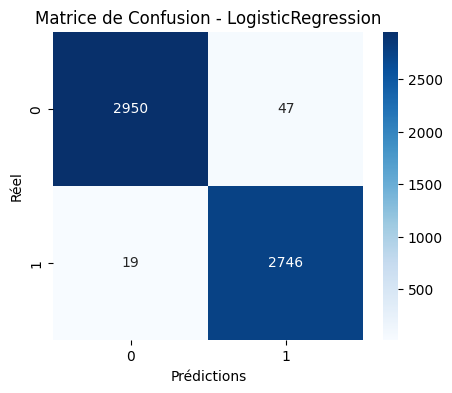


🔎 Optimisation : LinearSVC
Meilleur score (validation) : 0.9878937776620672
Meilleurs paramètres : {'clf__C': 1, 'tfidf__min_df': 3}

===== Performance sur Test Set =====
Accuracy : 0.9899340506768484
Precision : 0.989955732734472
Recall : 0.9899340506768484
F1_score : 0.98993522016002
Temps total (sec) : 7.47
AUC : 0.9991483949289857

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2997
           1       0.99      0.99      0.99      2765

    accuracy                           0.99      5762
   macro avg       0.99      0.99      0.99      5762
weighted avg       0.99      0.99      0.99      5762



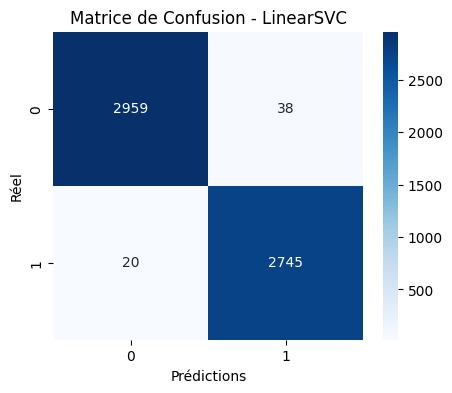


🔎 Optimisation : RandomForest
Meilleur score (validation) : 0.9838149787381759
Meilleurs paramètres : {'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__min_df': 3}

===== Performance sur Test Set =====
Accuracy : 0.9857688302672684
Precision : 0.9857796586861394
Recall : 0.9857688302672684
F1_score : 0.9857699635325788
Temps total (sec) : 204.45
AUC : 0.9986074078901084

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2997
           1       0.98      0.99      0.99      2765

    accuracy                           0.99      5762
   macro avg       0.99      0.99      0.99      5762
weighted avg       0.99      0.99      0.99      5762



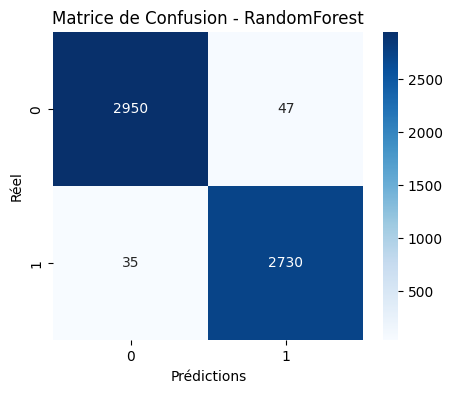


🔎 Optimisation : GradientBoosting
Meilleur score (validation) : 0.9621192397813069
Meilleurs paramètres : {'clf__learning_rate': 0.1, 'clf__n_estimators': 200, 'tfidf__min_df': 1}

===== Performance sur Test Set =====
Accuracy : 0.961471711211385
Precision : 0.9629450471189823
Recall : 0.961471711211385
F1_score : 0.9614852816428561
Temps total (sec) : 625.86
AUC : 0.994567865032

--- Rapport complet ---
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2997
           1       0.93      0.99      0.96      2765

    accuracy                           0.96      5762
   macro avg       0.96      0.96      0.96      5762
weighted avg       0.96      0.96      0.96      5762



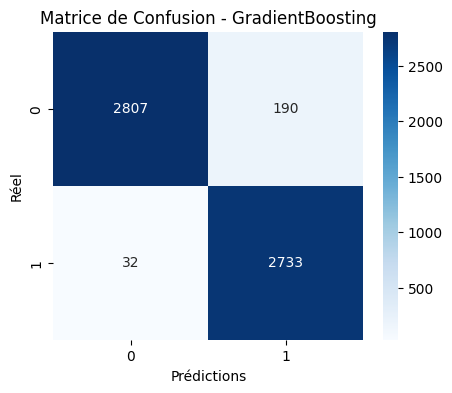

In [36]:
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

best_models = {}
best_scores = {}
best_model = None
best_score = 0
best_name = ""

for name, pipe in pipelines.items():
    print(f"\n🔎 Optimisation : {name}")

    start_time = time.time()

    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=3,
        n_jobs=-1,
        scoring="accuracy"
    )

    grid.fit(X_train, y_train)

    # Temps total
    total_time = time.time() - start_time

    # Meilleurs modèles
    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_

    print("Meilleur score (validation) :", grid.best_score_)
    print("Meilleurs paramètres :", grid.best_params_)

    # ======== PREDICTIONS ==========
    pred = grid.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, pred)

    # Precision, Recall, F1
    precision = precision_score(y_test, pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, pred, average="weighted", zero_division=0)

    # AUC (si binaire)
    auc = None
    if len(y.unique()) == 2:
        try:
            if hasattr(grid, "predict_proba"):
                proba = grid.predict_proba(X_test)[:, 1]
            elif hasattr(grid, "decision_function"):
                proba = grid.decision_function(X_test)
            else:
                proba = None

            if proba is not None:
                auc = roc_auc_score(y_test, proba)
        except:
            auc = None

    # Matrice de confusion
    cm = confusion_matrix(y_test, pred)

    # ====== AFFICHAGE DES METRIQUES ======
    print("\n===== Performance sur Test Set =====")
    print("Accuracy :", acc)
    print("Precision :", precision)
    print("Recall :", recall)
    print("F1_score :", f1)
    print("Temps total (sec) :", round(total_time, 2))

    if auc is not None:
        print("AUC :", auc)

    print("\n--- Rapport complet ---")
    print(classification_report(y_test, pred))

    # ====== MATRICE DE CONFUSION VISUELLE ======
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de Confusion - {name}")
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.show()

    # ====== SÉLECTION DU BEST MODEL ======
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name


In [37]:
print("\n==============================")
print("🏆 MEILLEUR MODÈLE :", best_name)
print("Score validation :", best_score)
print("==============================")



🏆 MEILLEUR MODÈLE : LinearSVC
Score validation : 0.9878937776620672


In [38]:
preds = best_model.predict(X_test)
print("\n🎯 Score sur le test set :", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))



🎯 Score sur le test set : 0.9899340506768484
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2997
           1       0.99      0.99      0.99      2765

    accuracy                           0.99      5762
   macro avg       0.99      0.99      0.99      5762
weighted avg       0.99      0.99      0.99      5762



In [39]:
joblib.dump(best_model, "../models/best_text_classifier.pkl")
print("📁 Modèle sauvegardé : best_text_classifier.pkl")


📁 Modèle sauvegardé : best_text_classifier.pkl
